In [ ]:
import math
import pandas as pd
import scipy.stats as stats
import numpy as np

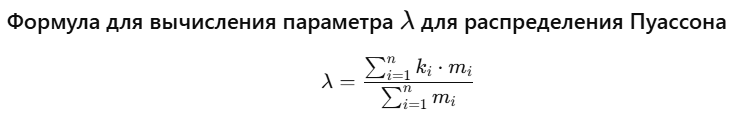

In [ ]:
def get_poisson_params(data):
    # Вычисляем взвешенную сумму произведений k и m
    weighted_sum = sum(k * m for k, m in zip(data['k'], data['m']))

    # Вычисляем общее количество событий
    total_count = sum(data['m'])

    # Рассчитываем взвешенное среднее (параметр Пуассона)
    weighted_mean = weighted_sum / total_count

    return weighted_mean


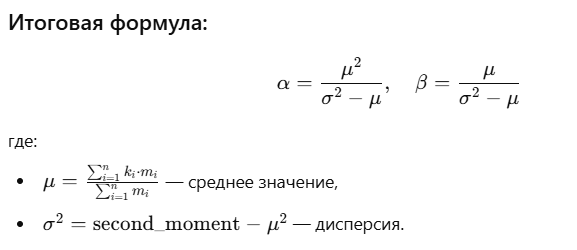

In [ ]:
def get_poisson_gamma_params(data):
    # Шаг 1: Считаем общее количество событий
    total_count = sum(data['m'])

    # Шаг 2: Вычисляем среднее значение (математическое ожидание)
    mean_value = sum(k * m for k, m in zip(data['k'], data['m'])) / total_count

    # Шаг 3: Вычисляем второй момент
    second_moment = sum((k**2) * m for k, m in zip(data['k'], data['m'])) / total_count

    # Шаг 4: Определяем дисперсию
    variance = second_moment - mean_value**2

    # Шаг 5: Рассчитываем параметры альфа (shape) и бета (rate)
    alpha = mean_value**2 / (variance - mean_value)
    beta = mean_value / (variance - mean_value)

    # Возвращаем параметры
    return alpha, beta

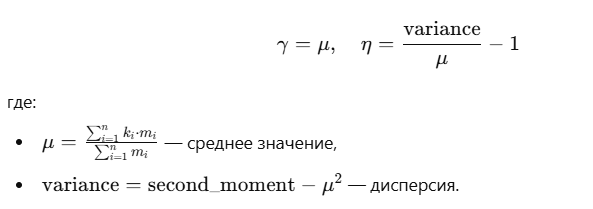

In [ ]:
def get_poisson_gaussian_params(data):
    # Шаг 1: Считаем общее количество событий
    total_count = sum(data['m'])

    # Шаг 2: Вычисляем среднее значение (математическое ожидание)
    mean_value = sum(k * m for k, m in zip(data['k'], data['m'])) / total_count

    # Шаг 3: Вычисляем второй момент
    second_moment = sum((k**2) * m for k, m in zip(data['k'], data['m'])) / total_count

    # Шаг 4: Определяем дисперсию
    variance = second_moment - mean_value**2

    # Шаг 5: Рассчитываем параметры гамма (γ) и эта (η)
    gamma_param = mean_value
    eta_param = (variance / mean_value) - 1

    # Возвращаем параметры
    return gamma_param, eta_param


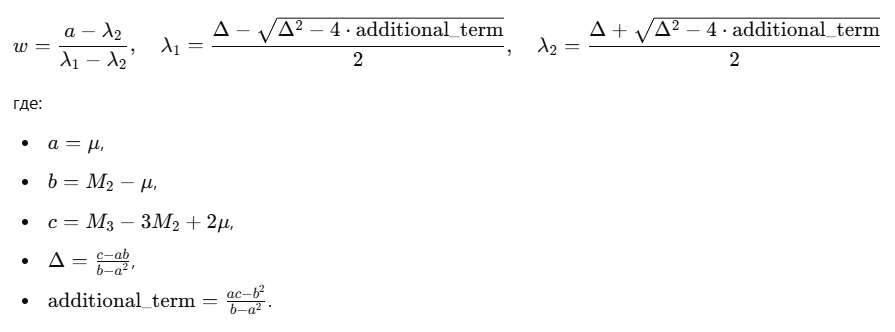

In [ ]:
def get_lemaire_params(data):
    # Шаг 1: Считаем общее количество событий
    total_count = sum(data['m'])

    # Шаг 2: Вычисляем математическое ожидание
    mean_value = sum(k * m for k, m in zip(data['k'], data['m'])) / total_count

    # Шаг 3: Вычисляем второй и третий моменты
    second_moment = sum((k**2) * m for k, m in zip(data['k'], data['m'])) / total_count
    third_moment = sum((k**3) * m for k, m in zip(data['k'], data['m'])) / total_count

    # Шаг 4: Вычисляем параметры Лемера
    a = mean_value
    b = second_moment - mean_value
    c = third_moment - 3 * second_moment + 2 * mean_value

    # Шаг 5: Рассчитываем дискриминант и дополнительные термины
    discriminant = (c - a * b) / (b - a**2)
    additional_term = (a * c - b**2) / (b - a**2)

    # Шаг 6: Вычисляем λ1 и λ2 (корни квадратного уравнения)
    λ1 = (discriminant - math.sqrt(discriminant**2 - 4 * additional_term)) / 2
    λ2 = (discriminant + math.sqrt(discriminant**2 - 4 * additional_term)) / 2

    # Шаг 7: Рассчитываем вес
    weight = (a - λ2) / (λ1 - λ2)

    # Возвращаем результат
    return weight, λ1, λ2


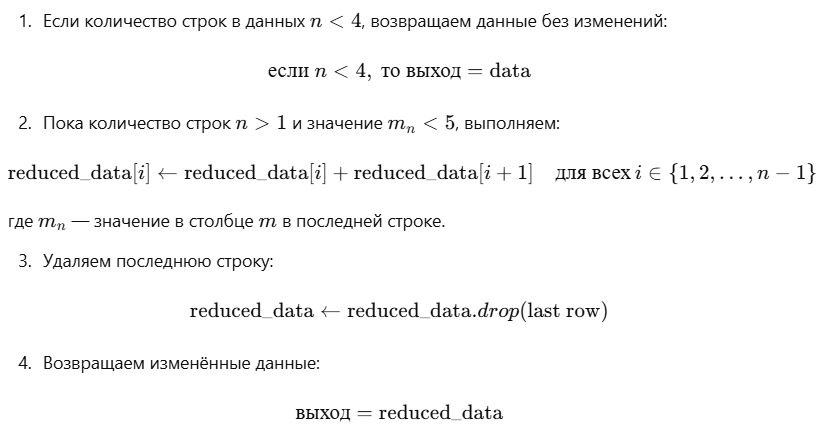

In [ ]:
def xlop(data):
    # Если данных меньше 4, возвращаем их без изменений
    if len(data) < 4:
        return data

    # Создаем копию данных, чтобы не изменять оригинал
    reduced_data = data.copy()

    # Пока длина данных больше 1 и значение 'm' в последней строке меньше 5
    while len(reduced_data) > 1 and reduced_data.iloc[-1]['m'] < 5:
        # Находим индекс предпоследней строки
        prev_idx = reduced_data.index[-2]

        # Добавляем значения последней строки к предпоследней для всех колонок
        for col in reduced_data.columns:
            reduced_data.loc[prev_idx, col] += reduced_data.iloc[-1][col]

        # Удаляем последнюю строку
        reduced_data = reduced_data.drop(reduced_data.index[-1])

    # Возвращаем обработанные данные
    return reduced_data


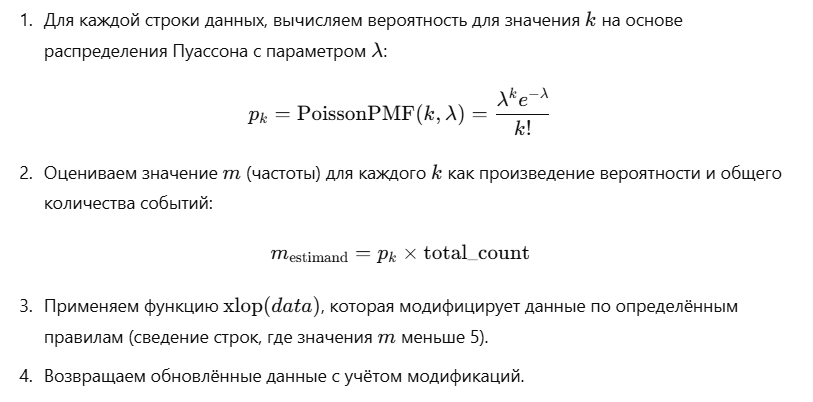

In [ ]:
def get_poisson_data(data, λ):
    # Создаем копию данных, чтобы не изменять оригинал
    poisson_dist = data.copy()

    # Считаем общее количество событий
    total_count = sum(data['m'])

    # Вычисляем вероятности для каждого значения k на основе параметра λ (лямбда)
    poisson_dist['p'] = stats.poisson.pmf(data['k'], λ)

    # Оцениваем значения m (частоты) на основе распределения Пуассона
    poisson_dist['m_estimand'] = round(poisson_dist['p'] * total_count)

    # Уменьшаем данные с использованием функции xlop
    return xlop(poisson_dist)


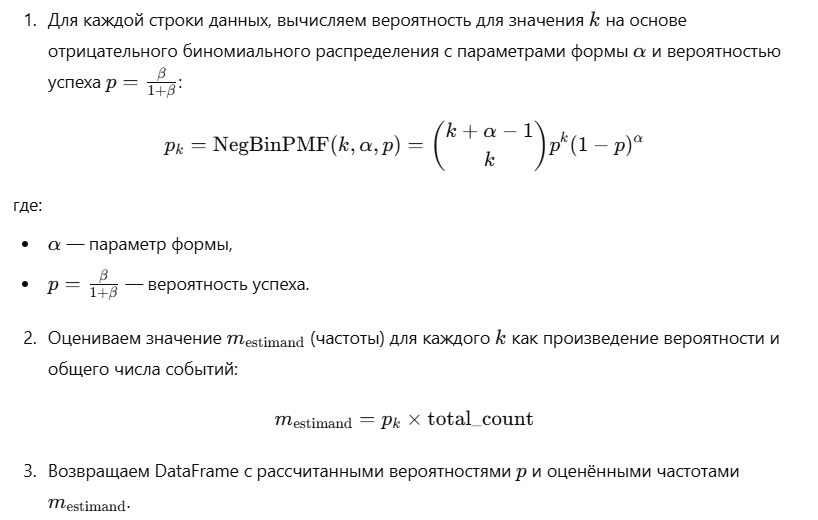

In [ ]:
def get_poisson_gamma_data(data, alpha, beta):
    # Создаем копию данных, чтобы не изменять оригинальный DataFrame
    pg_dist = data.copy()

    # Считаем общее количество событий
    total_count = sum(data['m'])

    # Вычисляем вероятности для каждого значения k на основе отрицательного биномиального распределения
    # alpha - это параметр формы, beta / (1 + beta) - вероятность успеха
    pg_dist['p'] = stats.nbinom.pmf(data['k'], alpha, beta / (1 + beta))

    # Оцениваем значения m (частоты) как произведение вероятности и общего числа событий
    pg_dist['m_estimand'] = round(pg_dist['p'] * total_count)

    # Возвращаем DataFrame с рассчитанными вероятностями и частотами
    return pg_dist


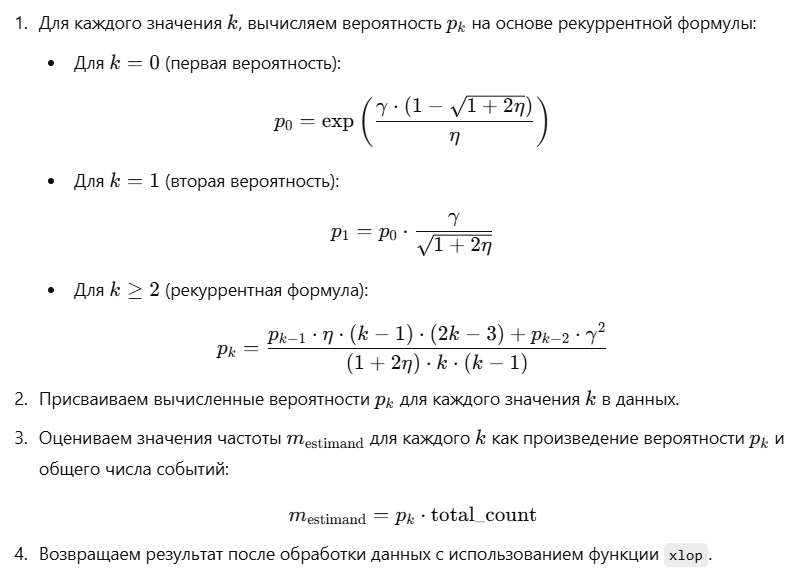

In [ ]:
def get_poisson_gaussian_data(data, gamma_param, eta_param):
    # Создаем копию данных, чтобы не изменять оригинальный DataFrame
    pg_dist = data.copy()

    # Считаем общее количество событий
    total_count = sum(data['m'])

    # Инициализируем массив вероятностей для значений k
    probabilities = np.zeros(data['k'].max() + 1)

    # Вычисляем вероятности на основе рекуррентной формулы
    for idx in range(probabilities.size):
        if idx == 0:
            # Первая вероятность для k=0
            probabilities[0] = math.exp(gamma_param * (1 - math.sqrt(1 + 2 * eta_param)) / eta_param)
        elif idx == 1:
            # Вероятность для k=1
            probabilities[1] = probabilities[0] * gamma_param / math.sqrt(1 + 2 * eta_param)
        else:
            # Рекуррентная формула для k>=2
            probabilities[idx] = (
                probabilities[idx - 1] * eta_param * (idx - 1) * (2 * idx - 3) +
                probabilities[idx - 2] * gamma_param**2
            ) / ((1 + 2 * eta_param) * idx * (idx - 1))

    # Присваиваем вычисленные вероятности для каждого значения k в данных
    pg_dist['p'] = probabilities[data['k']]

    # Оцениваем значения m (частоты) как произведение вероятностей и общего числа событий
    pg_dist['m_estimand'] = round(pg_dist['p'] * total_count)

    # Возвращаем результат после обработки xlop
    return xlop(pg_dist)


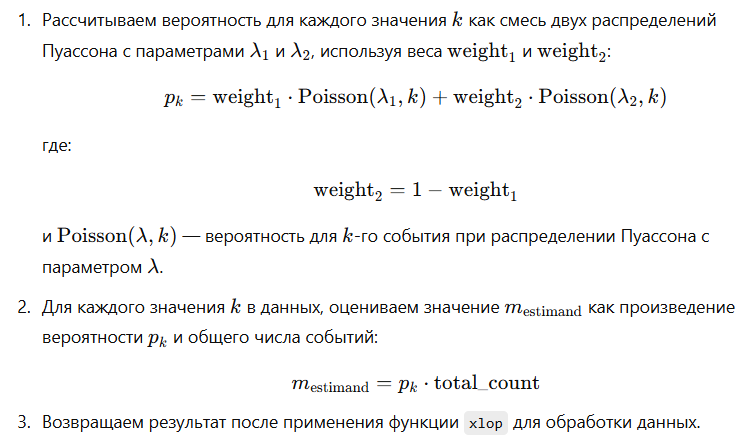

In [ ]:
def get_lemaire_data(data, weight1, λ1, λ2):
    # Создаем копию данных, чтобы не изменять оригинальный DataFrame
    lemaire_dist = data.copy()

    # Считаем общее количество событий
    total_count = sum(data['m'])

    # Вычисляем второй вес как 1 минус первый
    weight2 = 1 - weight1

    # Рассчитываем вероятности как смесь двух распределений Пуассона с параметрами λ1 и λ2
    # Используется веса для каждого из распределений
    lemaire_dist['p'] = (weight1 * stats.poisson.pmf(data['k'], λ1) +
                         weight2 * stats.poisson.pmf(data['k'], λ2))

    # Оцениваем значения m (частоты) как произведение вероятности и общего числа событий
    lemaire_dist['m_estimand'] = round(lemaire_dist['p'] * total_count)

    # Возвращаем результат после применения функции xlop для обработки данных
    return xlop(lemaire_dist)


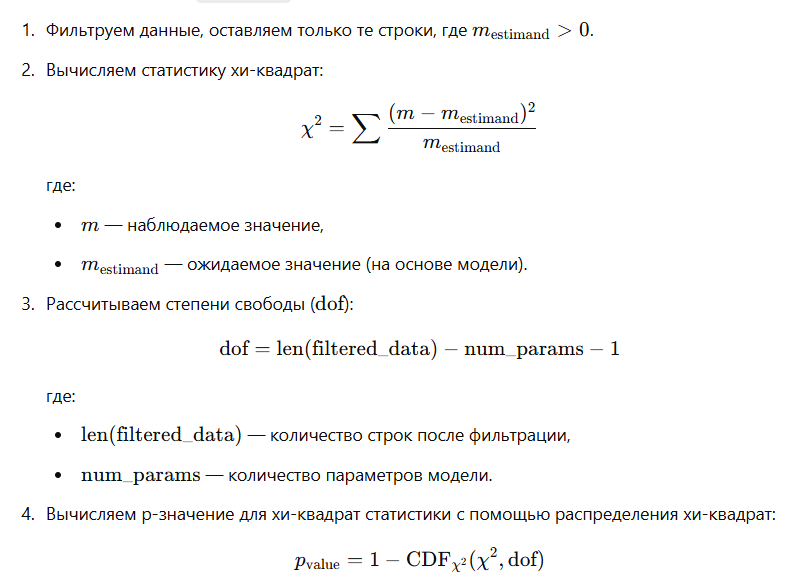

In [ ]:
def get_pvalue(new_data, num_params):
    # Фильтруем данные, оставляем только те строки, где m_estimand больше нуля
    filtered_data = new_data[new_data['m_estimand'] > 0]

    # Вычисляем статистику хи-квадрат
    chi_squared_stat = sum((filtered_data['m'] - filtered_data['m_estimand'])**2 / filtered_data['m_estimand'])

    # Степени свободы: количество строк минус количество параметров минус 1
    dof = len(filtered_data) - num_params - 1

    # Вычисляем p-значение для хи-квадрат статистики с помощью распределения хи-квадрат
    p_val = 1 - stats.chi2.cdf(chi_squared_stat, dof)

    return p_val


 **Печать результатов**




In [ ]:
def get_result(threshold, p_poisson, p_pg, p_pg_dist, p_lemaire):
    # Список методов для каждого из p-значений
    methods = ['Poisson', 'Poisson-Gamma', 'Inverse Gaussian', 'Lemaire']

    # Создаем DataFrame с методами и их соответствующими p-значениями
    results = pd.DataFrame({'Method': methods, 'p-value': [p_poisson, p_pg, p_pg_dist, p_lemaire]})

    # Инициализируем колонку Rank значением 'Not Suitable'
    results['Rank'] = 'Not Suitable'

    # Фильтруем модели, которые проходят пороговое значение p-value
    passing_models = results[results['p-value'] > threshold].sort_values('p-value', ascending=False)

    # Присваиваем ранг моделям, которые проходят порог
    if len(passing_models) > 0:
        for rank, idx in enumerate(passing_models.index, start=1):
            results.loc[idx, 'Rank'] = rank

    # Форматируем p-value до 14 знаков после запятой
    results['p-value'] = results['p-value'].map('{:.14f}'.format)

    return results


# Тестирование

In [ ]:
df = pd.DataFrame({
    'k': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'm': [1624, 490, 208, 98, 48, 23, 10, 5, 3, 2, 1]
})

α = 0.05

λ = get_poisson_params(df)
a, b = get_poisson_gamma_params(df)
g, h = get_poisson_gaussian_params(df)
a1, λ1, λ2 = get_lemaire_params(df)

result = get_result(
    α,
    get_pvalue(
        get_poisson_data(df, λ), 1),
    get_pvalue(
        get_poisson_gamma_data(df, a, b), 2),
    get_pvalue(
        get_poisson_gaussian_data(df, g, h), 2),
    get_pvalue(
        get_lemaire_data(df, a1, λ1, λ2), 3)
)

print(result)


             Method           p-value          Rank
0           Poisson  0.00000000000000  Not Suitable
1     Poisson-Gamma  0.99230828625810             1
2  Inverse Gaussian  0.00243887483111  Not Suitable
3           Lemaire  0.00000011461736  Not Suitable
